In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os
import tensorflow as tf
import numpy as np
import cv2
import time
import tifffile
import matplotlib.pyplot as plt
!pip install sewar
from PIL import Image
import skimage.measure  
import skimage.measure
import pywt
from math import log10, sqrt
import cv2
import numpy as np
from sewar.full_ref import mse, rmse, psnr, rmse_sw, uqi, ssim, ergas, scc, rase, sam, msssim, vifp, psnrb 
  



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=ea16ce5972d882d0a2bb71f64f35dcefa8b855ba39f7e677f6f36898f623fb3c
  Stored in directory: /root/.cache/pip/wheels/7a/38/6b/d066cfcb2b1c1c9b059b9ce1bdc4803b469359214e8dad4e3e
Successfully built sewar


In [ ]:
#@title
from abc import abstractmethod
import numpy as np
from math import pi
from cv2 import cartToPolar, Sobel, CV_32F
from matplotlib.pyplot import imshow, title, show

class XideaPetrovicMetric():
    # xydeas_petrovic parameters
    # The constants Γ, κ , σ  and Γα, κα, σα determine 
    # the  exact  shape  of  the  sigmoid  functions  used  to  form  the  edge  strength  and  
    # orientation  preservation  values.
    def __init__(self, image1, image2, fusedImage) -> None:
        self.EPS = np.finfo(float).eps
        self.GAMMA1 = 1
        self.GAMMA2 = 1
        self.K1 = -10
        self.K2 = -20
        self.DELTA1 = 0.5
        self.DELTA2 = 0.75
        self.L = 1
        self.image1 = image1
        self.image2 = image2
        self.fusedImage = fusedImage

    def _sobel_edge_detection(self, image, verbose=False):
        sx = Sobel(image, CV_32F, 1, 0)
        sy = Sobel(image, CV_32F, 0, 1)

        if verbose:
            imshow(sx, cmap='gray')
            title("Horizontal Edge")
            show()

            imshow(sy, cmap='gray')
            title("Vertical Edge")
            show()

        return cartToPolar(sx, sy)

    def _strenght_n_orientation(self, image):
        #The first input is the source image, which we convert to float. 
        #The second input is the output image, but we'll set that to None as we want the function 
        # call to return that for us. 
        #The third and fourth parameters specify the minimum and maximum values 
        # you want to appear in the output, which is 0 and 1 respectively, 
        #and the last output specifies how you want to normalize the image.
        # What I described falls under the NORM_MINMAX flag.
        #image = normalize(image.astype('float'), None, 0.0, 1.0, NORM_MINMAX)  
        # Kernels for convolving over the images
        #flt1= [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
        #flt2= [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
        # 1) get the map Sobel operator
        #fuseX = filter2D(image, -1, flt1)
        #fuseY = filter2D(image, -1, flt2)
        #   EQUIVALENT TO:
        s_x, s_y = self._sobel_edge_detection(image)
        #fusex
        # A Sobel edge operator is applied to yield the edge strength G
        g = np.sqrt(s_x**2 + s_y**2)
        # Orientation α(n,m) information for each pixel p
        alpha = np.arctan(s_y / ( s_x + self.EPS))
        return (g, alpha)

    def _perceptual_loss(self, gA, gF, alphaA, alphaF):
        # If g o alpha are followed by an underscore are ment to be considered written in uppercase
        # The relative strength and orientation values of g_AF(n,m) and alpha_AF(n,m) of an input 
        # image A with respect to F are formed as:
        
        #x, y = gA.shape
        #g_AF = np.zeros((x,y))
        #for n in range(x):
        #    for m in range(y):
        #        if (gA[n][m]  > gF[n][m]):
        #            g_AF[n][m] = gF[n][m] / ( gA[n][m] + EPS)
        #        else:
        #            g_AF[n][m] = gA[n][m] / ( gF[n][m] + EPS)
        bmap0 = gA > gF
        bmap1 = gA < gF
        
        g_AF0 = np.divide(gF, ( gA + self.EPS))
        g_AF1 = np.divide(gA, ( gF + self.EPS))

        g_AF = np.multiply(bmap0, g_AF0) + np.multiply(bmap1, g_AF1)

        alpha_AF = np.abs( np.abs(alphaA - alphaF) - pi/2) / (pi/2)

        qG_AF = self.GAMMA1 / (1 + np.exp( self.K1 *(g_AF - self.DELTA1)))
        qalpha_AF = self.GAMMA2 / (1 + np.exp( self.K2 *(alpha_AF - self.DELTA2) ))
        # These are used to derive the edge strength and orientation preservation values
        # QgAF(n,m)  and  QαAF(n,m)  model  perceptual  loss  of  information  in  F,  in  terms  of  
        # how well the strength and orientation values of a pixel p(n,m) in A are 
        # represented in the fused image. 
        #
        # Edge  information preservation values are then defined as
        q_AF = qG_AF * qalpha_AF
        # with  0  ≤  Q AF(n,m)  ≤  1 .  A  value  of  0  corresponds  to  the  complete  loss  of  edge  
        # information, at location (n,m), as transferred from A into F. QAF(n,m)=1 indicates 
        # “fusion” from A to F with no loss of information. 
        return q_AF

    def calculate(self):
        # EDGE Strenght and orientation for each pixels of the input images
        gA, alphaA = self._strenght_n_orientation(self.image1)
        gB, alphaB = self._strenght_n_orientation(self.image2)
        gF, alphaF = self._strenght_n_orientation(self.fusedImage)
        
        self.q_AF = self._perceptual_loss(gA, gF, alphaA, alphaF)
        self.q_BF = self._perceptual_loss(gB, gF, alphaB, alphaF)
        #
        # In general edge preservation values which 
        # correspond to pixels with high edge strength, should influence normalised weighted  
        # performance metric QP more than 
        # those of relatively low edge strength.Thus, wA(n,m)=[gA(n,m)]^L and 
        # wB(n,m)=[gB(n,m)]^L where L is a constant.
        #
        self.wA = gA #np.linalg.matrix_power(gA, L)
        self.wB = gB #np.linalg.matrix_power(gB, L)

        self.r = ( gF < gA ) | ( gF < gB )
        self.bitmap_artifacts = (gF > gA) & (gF > gB)

        return self.metric() #hook
    
    @abstractmethod
    def metric(self):
        pass

class InformationPreservation(XideaPetrovicMetric):
    def __init__(self, image1, image2, fusedImage) -> None:
        super().__init__(image1, image2, fusedImage)
    
    def metric(self):
        qP_ABF = sum( sum((self.q_AF * self.wA + self.q_BF * self.wB))) / sum ( sum((self.wA + self.wB)))
        return qP_ABF

class TotalFusionGain(XideaPetrovicMetric):
    def __init__(self, image1, image2, fusedImage) -> None:
        super().__init__(image1, image2, fusedImage)
    def metric(self):
        # local exclusive information in F, Q_delta
        # quantifies the total amount of local
        # exclusive information across the fused image.
    
        q_delta = np.abs(self.q_AF - self.q_BF)
    
        # For locations with strong correlation between the inputs Q_delta 
        # will be small or zero, indicating no exclusive
        # information. Conversely, in areas where one of the
        # inputs provides a meaningful feature that is not present
        # in the other this quantity will tend towards 1.

        # The common information component for all locations across the fused image
        q_common = (self.q_AF + self.q_BF  - q_delta) / 2
        # ½ is introduced as common information is contained in both Q_AF and Q_BF

        # Local estimates of exclusive information
        # components of each input
        q_delta_AF = self.q_AF - q_common
        # is the proportion of useful information fused in F that exists only in A
        q_delta_BF = self.q_BF - q_common
        # is the proportion of useful information fused in F that exists only in B

        # These quantities represent effectively, local fusion gain 
        # achieved by fusing A and B with respect to each individual {A, B}.
        
        # TOTAL FUSION GAIN
        return sum( sum((q_delta_AF * self.wA + q_delta_BF * self.wB))) / sum ( sum((self.wA + self.wB)))

class FusionLossArtifact(XideaPetrovicMetric):
    def __init__(self, image1, image2, fusedImage) -> None:
        super().__init__(image1, image2, fusedImage)
    
    def metric(self):
        # if gradient strength in F is larger than
        # that in the inputs, F contains artifacts; conversely, a
        # weaker gradient in F indicates a loss of input
        # information.
        loss = np.multiply(1 - self.q_AF, self.wA) + np.multiply(1 - self.q_BF, self.wB)
        loss = np.multiply(loss, self.r)
        loss = sum( sum(loss)) / sum ( sum((self.wA + self.wB)))

        #Artifacts calculation
        
        artifacts = 2 - self.q_AF - self.q_BF
        artifacts = np.multiply(self.bitmap_artifacts, artifacts)
        artifacts = sum( sum(artifacts)) / sum ( sum((self.wA + self.wB)))

        return (loss, artifacts)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/ProjectWork')

In [ ]:
print(os.listdir())

['PanGan_2.py', 'ops.py', 'README.md', 'hist_match.m', 'compute_res.py', 'pan_2_512.mat', 'ms_2_512.mat', 'ms_2_512.pkl', 'pan_2_512.pkl', 'task1.ipynb', 'Untitled1.ipynb', 'Untitled2.ipynb', 'image2.ipynb', 'image3.ipynb', 'data', 'DataSet.py', 'result', 'ms0.tif', 'xideapetrovic.py', 'Phase1 (1).ipynb', 'PanGan_b.py', 'Untitled0.ipynb', 'Untitled.txt', 'Untitled3.ipynb', 'Untitled4.ipynb', 'Untitled5.ipynb', 'test4.py', 'panGanp.py', 'trainp.py', 'train.py', 'Untitled6.ipynb', 'PanGan_x.py', 'model', 'PanGan.py', 'train_pf.py', 'test2.py', 'Phase1.ipynb', 'image1.ipynb', 'DWT.ipynb', 'SampleGAN.ipynb', 'GANmodify.ipynb', 'saved_model', 'Sample1phase1.ipynb', 'config.py', '__pycache__', 'log-generator', 'model-generator', 'GAN-ja.ipynb', 'crop8bit_1.npy', 'crop8bit_5.npy', 'crop8bit_3.npy', 'crop8bit_2.npy', 'crop8bit_4.npy', 'crop8bit_6.npy', 'crop8bit_7.npy', 'crop8bit_8.npy', 'crop8bit_9.npy', 'crop8bit_10.npy', 'crop8bit_11.npy', 'crop8bit_12.npy', 'crop8bit_15.npy', 'crop8bit_13.

In [ ]:
import tensorflow as tf
tf.__version__


'1.15.2'

In [ ]:
class PanGan(object):
    
    def __init__(self, pan_size, ms_size, batch_size,num_spectrum, ratio,init_lr=0.001,lr_decay_rate=0.99,lr_decay_step=1000, is_training=True):
        
        self.num_spectrum=num_spectrum
        self.is_training=is_training
        self.ratio = ratio
        self.batch_size=batch_size
        self.pan_size=pan_size
        self.ms_size=ms_size
        self.init_lr=init_lr
        self.lr_decay_rate=lr_decay_rate
        self.lr_decay_step=lr_decay_step
        self.build_model(pan_size, ms_size, batch_size,num_spectrum, is_training)
        
    def build_model(self, pan_size, ms_size, batch_size, num_spectrum, is_training):
        
        if is_training:
            with tf.name_scope('input'):
                self.pan_img=tf.placeholder(dtype=tf.float32, shape=(batch_size, pan_size, pan_size, 1), name='pan_placeholder')
                self.ms_img=tf.placeholder(dtype=tf.float32, shape=(batch_size,ms_size, ms_size, num_spectrum), name='ms_placeholder')
                self.ms_img_=tf.image.resize_images(images=self.ms_img, size=[pan_size, pan_size],
                                                               method=2)
                self.pan_img_hp=self.high_pass_1(self.pan_img, 'pan')
                self.pan_img_4=self.AddChannel(self.pan_img)
                self.ms_img_ = self.sigm(self.ms_img_)
                self.pan_img_4 = self.sigm(self.pan_img_4)
                self.ms_img_hp=self.high_pass(self.ms_img, 'ms')
            with tf.name_scope('PanSharpening'):
                self.PanSharpening_img= self.PanSharpening_model_dense(self.pan_img, self.ms_img)
                #self.PanSharpening_img_blur=self.blur(self.PanSharpening_img,7)
                self.PanSharpening_img_=tf.image.resize_images(images=self.PanSharpening_img, size=[ms_size, ms_size],
                                                               method=tf.image.ResizeMethod.BILINEAR)
                self.PanSharpening_img_hp=self.high_pass_1(self.PanSharpening_img)
            
            with tf.name_scope('d_loss'):
                with tf.name_scope('spatial_loss'):
                    spatial_pos=self.spatial_discriminator(self.pan_img_4, reuse=False)
                    spatial_neg=self.spatial_discriminator(self.PanSharpening_img, reuse=True)
                    # spatial_pos_loss= tf.reduce_mean(tf.square(spatial_pos-tf.random_uniform(shape=[self.batch_size,1],minval=0.7,maxval=1.2)))
                    # spatial_neg_loss= tf.reduce_mean(tf.square(spatial_neg-tf.random_uniform(shape=[self.batch_size,1],minval=0,maxval=0.3)))
                    spatial_pos_loss= tf.reduce_mean(tf.square(spatial_pos-tf.ones(shape=[batch_size,1], dtype=tf.float32)))
                    spatial_neg_loss= tf.reduce_mean(tf.square(spatial_neg-tf.zeros(shape=[batch_size,1], dtype=tf.float32)))
                    self.spatial_loss=spatial_pos_loss + spatial_neg_loss
                    tf.summary.scalar('spatial_loss', self.spatial_loss)
                with tf.name_scope('spectrum_loss'):
                    spectrum_pos=self.spectrum_discriminator(self.ms_img_, reuse=False)
                    spectrum_neg=self.spectrum_discriminator(self.PanSharpening_img, reuse=True)
                    # spectrum_pos_loss= tf.reduce_mean(tf.square(spectrum_pos-tf.random_uniform(shape=[self.batch_size,1],minval=0.7,maxval=1.2)))
                    # spectrum_neg_loss= tf.reduce_mean(tf.square(spectrum_neg-tf.random_uniform(shape=[self.batch_size,1],minval=0,maxval=0.3)))
                    spectrum_pos_loss= tf.reduce_mean(tf.square(spectrum_pos-tf.ones(shape=[batch_size,1], dtype=tf.float32)))
                    spectrum_neg_loss= tf.reduce_mean(tf.square(spectrum_neg-tf.zeros(shape=[batch_size,1], dtype=tf.float32)))
                    self.spectrum_loss=spectrum_pos_loss + spectrum_neg_loss
                    tf.summary.scalar('spectrum_loss', self.spectrum_loss)
            
            with tf.name_scope('g_loss'):
                spatial_loss_ad= tf.reduce_mean(tf.square(spatial_neg-tf.ones(shape=[batch_size,1], dtype=tf.float32)))
                tf.summary.scalar('spatial_loss_ad', spatial_loss_ad)
                spectrum_loss_ad=tf.reduce_mean(tf.square(spectrum_neg-tf.ones(shape=[batch_size,1], dtype=tf.float32)))
                tf.summary.scalar('spectrum_loss_ad', spectrum_loss_ad)
                g_spatital_loss= tf.reduce_mean(tf.square(self.PanSharpening_img_hp-self.pan_img_hp))
                #g_spatital_loss= tf.reduce_mean(tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.square(self.PanSharpening_img_hp-self.pan_img_hp),2)),1))
                tf.summary.scalar('g_spatital_loss', g_spatital_loss)
                g_spectrum_loss=tf.reduce_mean(tf.square(self.PanSharpening_img_-self.ms_img))
                #g_spectrum_loss=0.5*tf.reduce_mean(tf.reduce_sum(tf.square(self.PanSharpening_img_-self.ms_img),[2,3]))
                tf.summary.scalar('g_spectrum_loss', g_spectrum_loss)
                #self.g_loss= 5*spatial_loss_ad + spectrum_loss_ad+5*g_spatital_loss + g_spectrum_loss
                #self.g_loss= (spectrum_loss_ad+spatial_loss_ad) + 1000*(g_spatital_loss + 5*g_spectrum_loss)
                self.g_loss=g_spatital_loss + g_spectrum_loss
                tf.summary.scalar('g_loss', self.g_loss)
                
            # with tf.name_scope('valid_error'):
                # self.valid_spatital_error=tf.reduce_mean(tf.abs(self.PanSharpening_img_hp-self.pan_img_hp))
                # tf.summary.scalar('valid_spatital_error', self.valid_spatital_error)
                # self.valid_spectrum_error=tf.reduce_mean(tf.abs(self.PanSharpening_img-self.ms_img_))
                # tf.summary.scalar('valid_spectrum_error', self.valid_spectrum_error)
        else:
            with tf.name_scope('input'):
                # self.pan_img=tf.placeholder(dtype=tf.float32, shape=(batch_size, pan_size, pan_size, 1), name='pan_placeholder')
                # self.ms_img=tf.placeholder(dtype=tf.float32, shape=(batch_size,ms_size, ms_size, num_spectrum), name='ms_placeholder')
                self.pan_img=tf.placeholder(dtype=tf.float32, shape=(batch_size,None, None, 1), name='pan_placeholder')
                self.ms_img=tf.placeholder(dtype=tf.float32, shape=(batch_size,None, None, num_spectrum), name='ms_placeholder')
            self.PanSharpening_img=self.PanSharpening_model_dense(self.pan_img, self.ms_img)
            #self.PanSharpening_img_blur=self.blur(self.PanSharpening_img,7)
            # self.PanSharpening_img_=tf.image.resize_images(images=self.PanSharpening_img, size=[32, 32],
                                                               # method=tf.image.ResizeMethod.BILINEAR)
            PanSharpening_img_hp=self.high_pass_1(self.PanSharpening_img)
            pan_img_hp=self.high_pass_1(self.pan_img, 'pan')
            self.g_spectrum_loss=tf.reduce_mean(tf.square(self.PanSharpening_img-self.ms_img))
            self.g_spatial_loss=tf.reduce_mean(tf.square(PanSharpening_img_hp-pan_img_hp))

    def train(self):
        t_vars = tf.trainable_variables()
        d_spatial_vars = [var for var in t_vars if 'spatial_discriminator' in var.name]
        d_spectrum_vars=[var for var in t_vars if 'spectrum_discriminator' in var.name]
        g_vars = [var for var in t_vars if 'Pan_model' in var.name]
        with tf.name_scope('train_step'):
            self.global_step=tf.contrib.framework.get_or_create_global_step()
            self.learning_rate=tf.train.exponential_decay(self.init_lr, global_step=self.global_step, decay_rate=self.lr_decay_rate,
                                                          decay_steps=self.lr_decay_step)
            tf.summary.scalar('global learning rate', self.learning_rate)
            self.train_Pan_model=tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.g_loss, var_list=g_vars, global_step=self.global_step)
            self.train_spatial_discrim=tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.spatial_loss, var_list=d_spatial_vars)
            self.train_spectrum_discrim=tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.spectrum_loss, var_list=d_spectrum_vars)

    def PanSharpening_model_dense(self,pan_img, ms_img):
        with tf.variable_scope('Pan_model'):
            if self.is_training:
                with tf.name_scope('upscale'):
                    # de_weight=tf.get_variable('de_weight', [3,3,self.num_spectrum, self.num_spectrum],
                                            # initializer=tf.truncated_normal_initializer(stddev=1e-3) )
                    # ms_scale4 = tf.nn.conv2d_transpose(ms_img, de_weight, output_shape=[self.batch_size,self.pan_size,self.pan_size,self.num_spectrum],
                                                       # strides=[1,4,4,1],padding='SAME' )                            
                    ms_img=tf.image.resize_images(ms_img, [128, 128], method=2)
            input=tf.concat([ms_img,pan_img],axis=-1)
            with tf.variable_scope('layer1'):
                weights = tf.get_variable("w1", [9, 9, self.num_spectrum + 1, 64],
                                          initializer=tf.truncated_normal_initializer(stddev=1e-3))
                bias = tf.get_variable("b1", [64], initializer=tf.constant_initializer(0.0))
                conv1 = tf.contrib.layers.batch_norm(tf.nn.conv2d(input, weights, strides=[1, 1, 1, 1], padding='SAME') + bias,
                                                     decay=0.9,updates_collections=None, epsilon=1e-5, scale=True)
                conv1= tf.nn.relu(conv1)
                #conv1= self.sigm(conv1)
                #conv1= self.ft(conv1)

            with tf.variable_scope('layer2'):
                weights = tf.get_variable("w2", [7, 7, 64+5, 32],
                                          initializer=tf.truncated_normal_initializer(stddev=1e-3))
                bias = tf.get_variable("b1", [32], initializer=tf.constant_initializer(0.0))
                conv2 = tf.contrib.layers.batch_norm(tf.nn.conv2d(tf.concat([input,conv1],-1), weights, strides=[1, 1, 1, 1], padding='SAME') + bias,
                                                     decay=0.9,updates_collections=None, epsilon=1e-5, scale=True)
                conv2= tf.nn.relu(conv2)
                #conv2= self.sigm(conv2)
                #conv2= self.ft(conv2)
            with tf.variable_scope('layer3'):
                weights = tf.get_variable("w3", [7, 7, 5+64+32 , self.num_spectrum],
                                          initializer=tf.truncated_normal_initializer(stddev=1e-3))
                bias = tf.get_variable("b3", [self.num_spectrum], initializer=tf.constant_initializer(0.0))
                conv3 = (tf.nn.conv2d(tf.concat([input,conv1,conv2],-1), weights, strides=[1, 1, 1, 1], padding='SAME') + bias)
                                                    
                conv3= tf.tanh(conv3)
                

        return conv3
        
    def spatial_discriminator(self,img_hp,reuse=False):
        with tf.variable_scope('spatial_discriminator', reuse=reuse):
            with tf.variable_scope('layer_1'):
                weights = tf.get_variable("w_1", [3, 3, 4, 16],
                                          initializer=tf.truncated_normal_initializer(stddev=1e-3))
                bias = tf.get_variable("b_1", [16], initializer=tf.constant_initializer(0.0))
                conv1_spatial = tf.nn.conv2d(img_hp, weights, strides=[1, 2, 2, 1], padding='SAME') + bias
                conv1_spatial = self.lrelu(conv1_spatial)
                # print(conv1_vi.shape)
            with tf.variable_scope('layer_2'):
                weights = tf.get_variable("w_2", [3, 3, 16, 32],
                                          initializer=tf.truncated_normal_initializer(stddev=1e-3))
                bias = tf.get_variable("b_2", [32], initializer=tf.constant_initializer(0.0))
                conv2_spatial = tf.contrib.layers.batch_norm(
                    tf.nn.conv2d(conv1_spatial, weights, strides=[1, 2, 2, 1], padding='SAME') + bias, decay=0.9,
                    updates_collections=None, epsilon=1e-5, scale=True)
                conv2_spatial = self.lrelu(conv2_spatial)
                # print(conv2_vi.shape)
            with tf.variable_scope('layer_3'):
                weights = tf.get_variable("w_3", [3, 3, 32, 64],
                                          initializer=tf.truncated_normal_initializer(stddev=1e-3))
                bias = tf.get_variable("b_3", [64], initializer=tf.constant_initializer(0.0))
                conv3_spatial = tf.contrib.layers.batch_norm(
                    tf.nn.conv2d(conv2_spatial, weights, strides=[1, 2, 2, 1], padding='SAME') + bias, decay=0.9,
                    updates_collections=None, epsilon=1e-5, scale=True)
                conv3_spatial = self.lrelu(conv3_spatial)
                # print(conv3_vi.shape)
            with tf.variable_scope('layer_4'):
                weights = tf.get_variable("w_4", [3, 3, 64, 128],
                                          initializer=tf.truncated_normal_initializer(stddev=1e-3))
                bias = tf.get_variable("b_4", [128], initializer=tf.constant_initializer(0.0))
                conv4_spatial = tf.contrib.layers.batch_norm(
                    tf.nn.conv2d(conv3_spatial, weights, strides=[1, 2, 2, 1], padding='SAME') + bias, decay=0.9,
                    updates_collections=None, epsilon=1e-5, scale=True)
                conv4_spatial = self.lrelu(conv4_spatial)
                #conv4_spatial = tf.reshape(conv4_spatial, [self.batch_size, 4 * 4 * 128])
            with tf.variable_scope('layer_5'):
                weights = tf.get_variable("w_5", [3, 3, 128, 256],
                                          initializer=tf.truncated_normal_initializer(stddev=1e-3))
                bias = tf.get_variable("b_5", [256], initializer=tf.constant_initializer(0.0))
                conv5_spatial = tf.contrib.layers.batch_norm(
                    tf.nn.conv2d(conv4_spatial, weights, strides=[1, 2, 2, 1], padding='SAME') + bias, decay=0.9,
                    updates_collections=None, epsilon=1e-5, scale=True)
                conv5_spatial = self.lrelu(conv5_spatial)
            with tf.variable_scope('line_6'):
                weights = tf.get_variable("w_6", [3, 3, 256, 1],
                                          initializer=tf.truncated_normal_initializer(stddev=1e-3))
                bias = tf.get_variable("b_6", [1], initializer=tf.constant_initializer(0.0))
                conv6_spatial=tf.contrib.layers.batch_norm(
                    tf.nn.conv2d(conv5_spatial, weights, strides=[1, 1, 1, 1], padding='VALID') + bias, decay=0.9,
                    updates_collections=None, epsilon=1e-5, scale=True)
                conv6_spatial = self.lrelu(conv6_spatial)
                conv6_spatial=tf.reshape(conv6_spatial, [self.batch_size, 1])
                #line5_spatial = tf.matmul(conv4_spatial, weights) + bias
                # conv3_vi= tf.contrib.layers.batch_norm(conv3_vi, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True)
        return conv6_spatial

    def spectrum_discriminator(self,img,reuse=False):
        with tf.variable_scope('spectrum_discriminator', reuse=reuse):
            with tf.variable_scope('layer1_spectrum'):
                weights = tf.get_variable("w1_spectrum", [3, 3, self.num_spectrum, 16],
                                          initializer=tf.truncated_normal_initializer(stddev=1e-3))
                bias = tf.get_variable("b1_spectrum", [16], initializer=tf.constant_initializer(0.0))
                conv1_spectrum = tf.nn.conv2d(img, weights, strides=[1, 2, 2, 1], padding='SAME') + bias
                conv1_spectrum = self.lrelu(conv1_spectrum)
                # print(conv1_vi.shape)
            with tf.variable_scope('layer2_spectrum'):
                weights = tf.get_variable("w2_spectrum", [3, 3, 16, 32],
                                          initializer=tf.truncated_normal_initializer(stddev=1e-3))
                bias = tf.get_variable("b2_spectrum", [32], initializer=tf.constant_initializer(0.0))
                conv2_spectrum = tf.contrib.layers.batch_norm(
                    tf.nn.conv2d(conv1_spectrum, weights, strides=[1, 2, 2, 1], padding='SAME') + bias, decay=0.9,
                    updates_collections=None, epsilon=1e-5, scale=True)
                conv2_spectrum = self.lrelu(conv2_spectrum)
                # print(conv2_vi.shape)
            with tf.variable_scope('layer3_spectrum'):
                weights = tf.get_variable("w3_spectrum", [3, 3, 32, 64],
                                          initializer=tf.truncated_normal_initializer(stddev=1e-3))
                bias = tf.get_variable("b3_spectrum", [64], initializer=tf.constant_initializer(0.0))
                conv3_spectrum = tf.contrib.layers.batch_norm(
                    tf.nn.conv2d(conv2_spectrum, weights, strides=[1, 2, 2, 1], padding='SAME') + bias, decay=0.9,
                    updates_collections=None, epsilon=1e-5, scale=True)
                conv3_spectrum = self.lrelu(conv3_spectrum)
                # print(conv3_vi.shape)
            with tf.variable_scope('layer4_spectrum'):
                weights = tf.get_variable("w4_spectrum", [3, 3, 64, 128],
                                          initializer=tf.truncated_normal_initializer(stddev=1e-3))
                bias = tf.get_variable("b4_spectrum", [128], initializer=tf.constant_initializer(0.0))
                conv4_spectrum = tf.contrib.layers.batch_norm(
                    tf.nn.conv2d(conv3_spectrum, weights, strides=[1, 2, 2, 1], padding='SAME') + bias, decay=0.9,
                    updates_collections=None, epsilon=1e-5, scale=True)
                conv4_spectrum = self.lrelu(conv4_spectrum)
                #conv4_spectrum = tf.reshape(conv4_spectrum, [self.batch_size, 1 * 1 * 128])
            with tf.variable_scope('layer5_spectrum'):
                weights = tf.get_variable("w5_spectrum", [3, 3, 128, 256],
                                          initializer=tf.truncated_normal_initializer(stddev=1e-3))
                bias = tf.get_variable("b5_spectrum", [256], initializer=tf.constant_initializer(0.0))
                conv5_spectrum = tf.contrib.layers.batch_norm(
                    tf.nn.conv2d(conv4_spectrum, weights, strides=[1, 2, 2, 1], padding='SAME') + bias, decay=0.9,
                    updates_collections=None, epsilon=1e-5, scale=True)
                conv5_spectrum = self.lrelu(conv5_spectrum)
                #conv4_spectrum = tf.reshape(conv4_spectrum, [self.batch_size, 1 * 1 * 128])
            with tf.variable_scope('line6_spectrum'):
                weights = tf.get_variable("w6_spectrum", [3 , 3 , 256, 1],
                                          initializer=tf.truncated_normal_initializer(stddev=1e-3))
                bias = tf.get_variable("b6_spectrum", [1], initializer=tf.constant_initializer(0.0))
                conv6_spectrum=tf.contrib.layers.batch_norm(
                    tf.nn.conv2d(conv5_spectrum, weights, strides=[1, 1, 1, 1], padding='VALID') + bias, decay=0.9,
                    updates_collections=None, epsilon=1e-5, scale=True)
                conv6_spectrum=self.lrelu(conv6_spectrum)
                conv6_spectrum=tf.reshape(conv6_spectrum, [self.batch_size, 1])
                #line5_spectrum = tf.matmul(conv4_spectrum, weights) + bias
                # conv3_vi= tf.contrib.layers.batch_norm(conv3_vi, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True)
        return conv6_spectrum
        
    def high_pass(self, img, type='PanSharepening'):
        if type=='pan':
            input=img
            for i in range(self.num_spectrum-1):
                input=tf.concat([input,img],axis=-1)
            img=input
        blur_kerel=np.zeros(shape=(13,13,self.num_spectrum, self.num_spectrum), dtype=np.float32)
        value=1/169*np.ones(shape=(13,13), dtype=np.float32)
        for i in range(self.num_spectrum):
            blur_kerel[:,:,i,i]=value
        img_lp=tf.nn.conv2d(img,tf.convert_to_tensor(blur_kerel),strides=[1,1,1,1], padding='SAME')
        img_hp=tf.reshape(tf.reduce_mean(img-img_lp,3),[self.batch_size,self.pan_size,self.pan_size,1])
        return tf.abs(img_hp)
        
    def blur(self, img, kernel_size,gaussian_variance=1):
        blur_kerel=np.zeros(shape=(kernel_size, kernel_size, self.num_spectrum, self.num_spectrum), dtype=np.float32)
        value=self.generate_Gauss(kernel_size)
        for i in range(self.num_spectrum):
            blur_kerel[:,:,i,i]=value
        img_blur=tf.nn.conv2d(img,tf.convert_to_tensor(blur_kerel),strides=[1,1,1,1], padding='SAME')
        return img_blur
        
    def high_pass_1(self, img, type='PanSharepening'):
        if type=='pan':
            input=img
            for i in range(3):
                input=tf.concat([input,img],axis=-1)
            img=input
        blur_kerel=np.zeros(shape=(3,3,4,4), dtype=np.float32)
        value=np.array([[0.,1.,0.],[1.,-4.,1.],[0.,1.,0.]])
        for i in range(4):
            blur_kerel[:,:,i,i]=value
        img_hp=tf.nn.conv2d(img,tf.convert_to_tensor(blur_kerel),strides=[1,1,1,1], padding='SAME')
        #img_hp=tf.reshape(tf.reduce_mean(img_hp,3),[self.batch_size,128,128,1])
        #img_hp=img-img_lp
        return tf.abs(img_hp)
        
    def generate_Gauss(self,kernel_size,gaussian_variance=1):
        x = np.arange(0, kernel_size, 1, float)
        y = x[:, np.newaxis]
        x0 = y0 = kernel_size // 2
        kernel=np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / 2.0 / gaussian_variance/ gaussian_variance)
        kernel=kernel/np.sum(kernel)
        return kernel
       
    def lrelu(self,x, leak=0.2):
        return tf.maximum(x, leak * x)
    
    def sigm(self, x,b=0.75):
      a= tf.keras.activations.sigmoid(10*(x+b))
      b= tf.keras.activations.sigmoid(10*(x-b))
      
      am= tf.keras.activations.sigmoid(10*(1-b))
      bm= tf.keras.activations.sigmoid(10*(-1-b))
      ab= am-bm
      amf= 1/ab
      v= amf*(a-b)
      return v

    #def ft(self,x,t=0.5):
     # if(x>0):
      #  return tf.nn.relu(x) * tf.nn.sigmoid(x) +t
      #else:
       # return t

      

      


    def AddChannel(self, x):
        input=x
        for i in range(self.num_spectrum-1):
            input=tf.concat([input,x],axis=-1)
        return input

In [ ]:
from DataSet import DataSet
def print_current_training_stats(error_pan_model, error_ms_model, error_g_model, global_step, learning_rate, time_elapsed):
    stats = 'Step: {}/{} ----- Cur_lr: {:1.7f} ----- Time: {:>2.2f} sec.'.format(global_step, FLAGES.iters,
                                                                                 learning_rate, time_elapsed)
    losses =  ' | spatial loss: {}'.format(error_pan_model)
    losses += ' | spectrual loss: {}'.format(error_ms_model)
    losses += ' | generator loss: {}'.format(error_g_model)
    print(stats)
    print(losses + '\n')
    
def print_current_training_stats_valid(error_spatial, error_spectrual, global_step, learning_rate, time_elapsed):
    stats = 'Valid_Step: {}/{} ----- Cur_lr: {:1.7f} ----- Time: {:>2.2f} sec.'.format(global_step, FLAGES.iters,
                                                                                 learning_rate, time_elapsed)
    losses =  ' | spatial error: {}'.format(error_spatial)
    losses += ' | spectrual error: {}'.format(error_spectrual)
    print(stats)
    print(losses + '\n')

def trainer():
    model=PanGan(FLAGES.pan_size, FLAGES.ms_size, FLAGES.batch_size, FLAGES.num_spectrum, FLAGES.ratio,
                 FLAGES.lr,FLAGES.decay_rate,FLAGES.decay_step,is_training=True)
    model.train()
    dataset=DataSet(FLAGES.pan_size, FLAGES.ms_size, FLAGES.img_path, FLAGES.data_path, FLAGES.batch_size,
                    FLAGES.stride)
    DataGenerator=dataset.data_generator
    
    dataset_valid=DataSet(FLAGES.pan_size, FLAGES.ms_size, FLAGES.img_path, FLAGES.data_path, FLAGES.batch_size,
                    FLAGES.stride, 'valid')
    DataGenerator_valid=dataset_valid.data_generator

    merge_summary=tf.summary.merge_all()
    if not os.path.exists(FLAGES.log_dir):
        os.makedirs(FLAGES.log_dir)
    if not os.path.exists(FLAGES.model_save_dir):
        os.makedirs(FLAGES.model_save_dir)

    with tf.Session() as sess:
        train_writer=tf.summary.FileWriter(FLAGES.log_dir, sess.graph)
        saver=tf.train.Saver(max_to_keep=None)
        saver_g=tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'Pan_model'),max_to_keep=None)
        init_op=tf.global_variables_initializer()
        sess.run(init_op)

        if FLAGES.is_pretrained:
            saver.restore(sess, './model/qk/PanNet-107000')
        for training_itr in range(FLAGES.iters):
            t1 = time.time()
            pan_batch, ms_batch=next(DataGenerator)
            for i in range(2):
                _, error_pan_model = sess.run([model.train_spatial_discrim, model.spatial_loss],feed_dict={model.pan_img: pan_batch, model.ms_img: ms_batch})
                _, error_ms_model = sess.run([model.train_spectrum_discrim, model.spectrum_loss],feed_dict={model.pan_img: pan_batch, model.ms_img: ms_batch })

            _, error_g_model, global_step, summary, learning_rate = sess.run([model.train_Pan_model, model.g_loss,model.global_step, merge_summary,model.learning_rate],
                                                                             feed_dict={model.pan_img: pan_batch, model.ms_img: ms_batch})
            error_pan_model=sess.run(model.spatial_loss,feed_dict={model.pan_img: pan_batch, model.ms_img: ms_batch})
            error_ms_model=sess.run(model.spectrum_loss,feed_dict={model.pan_img: pan_batch, model.ms_img: ms_batch})					
            print_current_training_stats(error_pan_model, error_ms_model, error_g_model, global_step, learning_rate, time.time()-t1)
            train_writer.add_summary(summary, global_step)
            
            # if (global_step + 1) %  FLAGES.valid_iters == 0:
                # t1 = time.time()
                # pan_valid_batch, ms_valid_batch=next(DataGenerator_valid)
                # error_spatial,error_spectrum = sess.run([model.valid_spatital_error, model.valid_spectrum_error],feed_dict={model.pan_img: pan_valid_batch, model.ms_img: ms_valid_batch})
                # print_current_training_stats_valid(error_spatial, error_spectrum, global_step, learning_rate, time.time()-t1)
            
            if (global_step + 1) %  FLAGES.model_save_iters == 0:
                print(FLAGES.model_save_dir,os.listdir(FLAGES.model_save_dir))
                saver.save(sess=sess, save_path=FLAGES.model_save_dir + '/' + 'PanNet', global_step=(global_step+1) )
                saver_g.save(sess=sess, save_path=FLAGES.model_save_dir + '/' + 'Generator', global_step=(global_step+1)  )
                print('\nModel checkpoint saved...\n')

            if global_step == FLAGES.iters:
                break
        print('Training done.')

In [ ]:
class FLAGES(object):

    pan_size= 128
    
    ms_size=32
    
    
    num_spectrum=4
    
    ratio=4
    stride=16
    norm=True
    
    
    batch_size=32
    lr=0.0001
    decay_rate=0.99
    decay_step=10000
    
    img_path='./data/source_data'
    data_path='./data/train/train_qk.h5'
    log_dir='./log-generator'
    model_save_dir='./model-generator'
    
    is_pretrained=False
    
    iters=1000
    model_save_iters = 100
    valid_iters=1000

In [ ]:
FLAGES.iters = 1000
FLAGES.model_save_iters = 100
FLAGES.model_save_dir='./model-generator'
FLAGES.log_dir='./log-generator'
FLAGES.batch_size = 8

In [ ]:
def main(*args):
    pass

In [ ]:
tf.reset_default_graph()
tf.app.run(trainer())

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
INFO:tensorflow:Summary name global learning rate is illegal; using global_learning_rate instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Step: 0/1000 ----- Cur_lr: 0.0001000 ----- Time: 6.12 sec.
 | spatial loss: 0.9679125547409058 | spectrual loss: 0.9947037100791931 | generator loss: 0.2847190499305725

Step: 1/1000 ----- Cur_lr: 0.0001000 ----- Time: 0.14 sec.
 | spatial loss: 0

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


test

In [ ]:
import tensorflow as tf
import os 
import numpy as np
import cv2
from PanGan_2 import PanGan 
from DataSet import DataSet
from config import FLAGES
from sewar.full_ref import uqi
from skimage import data
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv


import time
import os
import tifffile
import matplotlib.pyplot as plt
try:
    from osgeo import gdal
    print('from osgeo')
except:
    import gdal


from osgeo


In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

FLAGS = tf.app.flags.FLAGS

tf.app.flags.DEFINE_string('f', '', 'kernel')
tf.app.flags.DEFINE_string('pan_size',
                           default_value=None,
                           docstring='pan image size')
tf.app.flags.DEFINE_string('ms_size',
                           default_value=None,
                           docstring='ms image size')
tf.app.flags.DEFINE_integer('batch_size',
                           default_value=1,
                           docstring='img batch')
tf.app.flags.DEFINE_integer('num_spectrum',
                           default_value=4,
                           docstring='spectrum num')
tf.app.flags.DEFINE_integer('ratio',
                           default_value=4,
                           docstring='pan image/ms img')
tf.app.flags.DEFINE_string('model_path',
                           default_value='./model-generator/Generator-1000',

                           docstring='pan image/ms img') 
tf.app.flags.DEFINE_string('test_path',
                           default_value='./data/test_gt_gf',
                           docstring='test img data')                            
tf.app.flags.DEFINE_string('result_path',
                           default_value='./result',
                           docstring='result img')                          
tf.app.flags.DEFINE_boolean('norm',
                           default_value=True,
                           docstring='if norm') 

In [ ]:
tf.flags.FLAGS.__delattr__('model_path')
tf.app.flags.DEFINE_string('model_path',default_value='./model-generator/Generator-1000',docstring="")

In [ ]:
#@title
def main(argv):
    if not os.path.exists(FLAGS.result_path):
        os.makedirs(FLAGS.result_path)
    model=PanGan(FLAGS.pan_size,FLAGS.ms_size, FLAGS.batch_size, FLAGS.num_spectrum, FLAGS.ratio,0.001, 0.99, 1000,False)
    saver=tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, FLAGS.model_path)
        ms_test_path= FLAGS.test_path + '/lrms'
        pan_test_path=FLAGS.test_path + '/pan'
        for img_name in os.listdir(ms_test_path):
            start=time.time()
            print(img_name)
            pan, ms = read_img(pan_test_path, ms_test_path, img_name,FLAGS)
            print("ms",ms.shape,"pan",pan.shape)
          
            PanSharpening,error,error2= sess.run([model.PanSharpening_img,model.g_spectrum_loss,model.g_spatial_loss], feed_dict={model.pan_img:pan, model.ms_img:ms})
            PanSharpening=PanSharpening*127.5+127.5
            PanSharpening=PanSharpening.squeeze()
            PanSharpening=PanSharpening.astype('uint8')
            end=time.time()
            print(end-start)
            save_name=img_name.split('.')[0] + '.PNG'
            save_path=os.path.join(FLAGS.result_path,save_name)
            cv2.imwrite(save_path, PanSharpening)
            # img_write(PanSharpening,save_path)
            PanSharpening=cv2.cvtColor(PanSharpening[:,:,0:3], cv2.COLOR_BGR2RGB)
            cv2.imwrite(save_path, PanSharpening)
            tifffile.imsave(save_path, PanSharpening)
            print(f"{'-'*20} \n{img_name} done\nspectrum error = {str(error)} \nspatial error ={str(error2)}")
            display(pan,ms,PanSharpening)

            
def read_img(pan_test_path, ms_test_path, img_name, FLAGS):
    pan_img_path=os.path.join(pan_test_path, img_name)
    ms_img_path=os.path.join(ms_test_path, img_name)
    #pan_img=cv2.imread(pan_img_path, -1)
    #pan_img=gdal_read(pan_img_path,'pan')
    pan_img=read8bit(pan_img_path,'pan')
    h,w=pan_img.shape
    pan_img=pan_img.reshape((1,h,w,1))
    #ms_img=cv2.imread(ms_img_path, -1)
    #ms_img=gdal_read(ms_img_path,'ms')
    ms_img=read8bit(ms_img_path,'ms')
    h,w,c=ms_img.shape
    ms_img=cv2.resize(ms_img,(4*w,4*h),interpolation=cv2.INTER_CUBIC)
    h,w,c=ms_img.shape
    
    # ms_img=np.array(ms_img)
    # h,w,c=ms_img.shape
    # ms_img=cv2.resize(ms_img,(4*w,4*h),interpolation=cv2.INTER_CUBIC)
    ms_img=ms_img.reshape((1,h,w,c))
   
    return pan_img, ms_img
    
def gdal_read(path,name):
    data=gdal.Open(path)
    w=data.RasterXSize
    h=data.RasterYSize
    img=data.ReadAsArray(0,0,w,h)
    if name == 'ms':
        img=np.transpose(img,(1,2,0))
    img=(img-1023.5)/1023.5
    return img
    
def read8bit(path,name):
    if name=='ms':
        v='src'
    else:
        v='pan'
    v='I'
    #img=scio.loadmat(path)[v]
    img=np.load(path)
    img=(img-127.5)/127.5
    return img
    
def img_write(img_array,save_path):
    datatype=gdal.GDT_UInt16
    h,w,c=img_array.shape
    driver=gdal.GetDriverByName('GTiff')
    data=driver.Create(save_path, w, h, c, datatype)
    for i in range(c):
        data.GetRasterBand(i+1).WriteArray(img_array[:,:,i])
    del data

def display(pan,ms,fused,size=(18,6)):
    print("fused shape",fused.shape)
    titles = ['pan','ms','Fused']
    ms0 = ms[0] 
    ms0 = ms0*127.5+127.5
    ms0 = ms0.astype('uint8')
    ms0 = cv2.cvtColor(ms0[:,:,0:3], cv2.COLOR_BGR2RGB)
    print('ms0',ms0.shape)
    fig,ax = plt.subplots(nrows=1,ncols=3,figsize=size)
    pn0 = np.squeeze(pan[0],axis=2)
    ax[0].imshow(pn0, cmap='gray')
    ax[1].imshow(ms0)
    ax[2].imshow(fused)
    for axis in ax:
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        axis.set_xticklabels([])
        axis.set_yticklabels([])
    for axis,title in zip(ax,titles):
        axis.set_title(title)
    plt.show()
    u_ms= uqi(ms[0][:,:,:3],fused)
    u_pan= uqi(pan[0],fused[:,:,:1])
    # average pooling ms into 1 band for correction of result
    ms[0].mean()
    # ssim_pan= ssim(pan[0],fused[:,:,:1],'p')
    # ssim_ms= ssim(ms[0][:,:,:3],fused,'m')
    # es_pan= edgestrength(pan[0],fused[:,:,:1])
    # es_ms= edgestrength(ms[0][:,:,:3],fused,'m')
    # tfg_pan= tfg(pan[0],fused[:,:,:1],)
    # tfg_ms= tfg(ms[0][:,:,:3],fused,'m')
    # cc_pan= cc(pan[0],fused[:,:,:1],)
    # cc_ms= cc(ms[0][:,:,:3],fused,'m')
    # mi_pan= MI(pan[0],fused[:,:,:1],)
    # mi_ms= MI(ms[0][:,:,:3],fused,'m')




In [ ]:
try:
    tf.reset_default_graph()
    tf.app.run(main(None))
except Exception as e:
    print(e)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def read_img(pan_test_path, ms_test_path, img_name, FLAGS):
    pan_img_path=os.path.join(pan_test_path, img_name)
    ms_img_path=os.path.join(ms_test_path, img_name)
    
    #pan_img=cv2.imread(pan_img_path, -1)
    #pan_img=gdal_read(pan_img_path,'pan')
    pan_img=read8bit(pan_img_path,'pan')
    h,w=pan_img.shape
    pan_img=pan_img.reshape((1,h,w,1))
    #ms_img=cv2.imread(ms_img_path, -1)
    #ms_img=gdal_read(ms_img_path,'ms')
    ms_img=read8bit(ms_img_path,'ms')
    h,w,c=ms_img.shape
    ms_img=cv2.resize(ms_img,(4*w,4*h),interpolation=cv2.INTER_CUBIC)
    h,w,c=ms_img.shape
    
    # ms_img=np.array(ms_img)
    # h,w,c=ms_img.shape
    # ms_img=cv2.resize(ms_img,(4*w,4*h),interpolation=cv2.INTER_CUBIC)
    ms_img=ms_img.reshape((1,h,w,c))
   
    return pan_img, ms_img


In [ ]:
def gdal_read(path,name):
    data=gdal.Open(path)
    w=data.RasterXSize
    h=data.RasterYSize
    img=data.ReadAsArray(0,0,w,h)
    if name == 'ms':
        img=np.transpose(img,(1,2,0))
    img=(img-1023.5)/1023.5
    return img


In [ ]:
def read8bit(path,name):
    if name=='ms':
        v='src'
    else:
        v='pan'
    v='I'
    #img=scio.loadmat(path)[v]
    img=np.load(path)
    img=(img-127.5)/127.5
    return img


In [ ]:
def img_write(img_array,save_path):
    datatype=gdal.GDT_UInt16
    h,w,c=img_array.shape
    driver=gdal.GetDriverByName('GTiff')
    data=driver.Create(save_path, w, h, c, datatype)
    for i in range(c):
        data.GetRasterBand(i+1).WriteArray(img_array[:,:,i])
    del data


In [ ]:
def display(pan,ms,fused,size=(18,6)):
    print("fused shape",fused.shape)
    titles = ['pan','MS band 0','MS band 1','MS band 2','MS band 3','Fused']
    fig,ax = plt.subplots(nrows=1,ncols=6,figsize=size)
    ax[0].imshow(pan[0], cmap= 'gray')
    ax[1].imshow(ms[0][:,:,0], cmap= 'gist_earth')
    ax[2].imshow(ms[0][:,:,1], cmap= 'gist_earth')
    ax[3].imshow(ms[0][:,:,2], cmap= 'gist_earth')
    ax[4].imshow(ms[0][:,:,3], cmap= 'gist_earth')
    ax[5].imshow(fused, cmap= 'gist_earth')
    for axis in ax:
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        axis.set_xticklabels([])
        axis.set_yticklabels([])
    for axis,title in zip(ax,titles):
        axis.set_title(title)
    plt.show()
    u_ms= uqi(ms[0][:,:,:3],fused)
    print('UQI fused/MS=' ,u_ms)
    u_pan= uqi(pan[0],fused[:,:,:1])
    print('UQI fused/PAN= ',u_pan)


In [ ]:
os.listdir("data/test_gt_gf")  

['pan', 'hrms', 'lrms']

In [ ]:
!pip install rasterio

In [ ]:
import rasterio

Image1


(456, 404, 3)
(456, 404, 3)
(456, 404, 3)


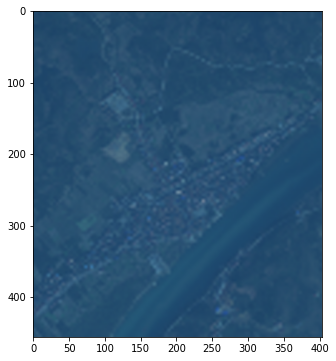

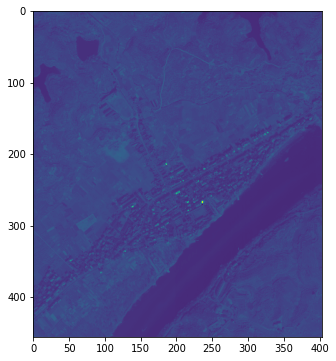

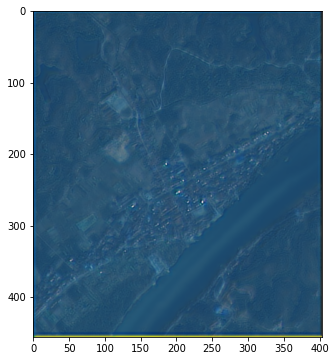

In [ ]:
result1 = Image.open('/content/drive/MyDrive/ProjectWork/result/crop8bit_1.PNG')
fused= np.array(result1)
pan,ms =  read_img('data/test_gt_gf/pan', 'data/test_gt_gf/lrms', 'crop8bit_1.npy',None)
ms0 = ms[0] 
ms0 = ms0*127.5+127.5
ms0 = ms0.astype('uint8')
ms0 = cv2.cvtColor(ms0[:,:,0:3], cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(ms0)
print(ms0.shape)
pan0 = pan[0].reshape(pan.shape[1],pan.shape[2])
plt.figure(figsize=(6,6))
plt.imshow(pan0)
print(ms0.shape)
plt.figure(figsize=(6,6))
plt.imshow(fused)
print(ms0.shape)

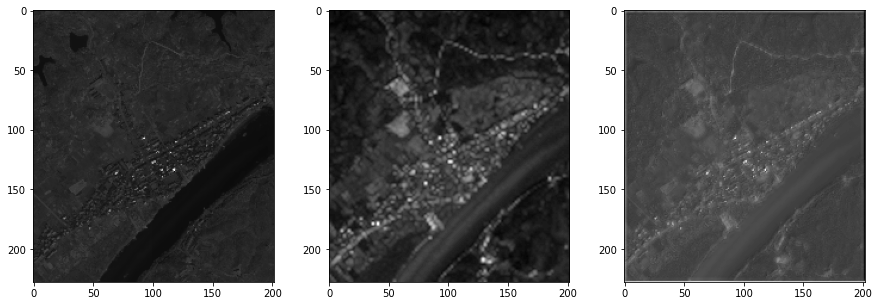

(228, 202) (228, 202) (228, 202)


In [ ]:
import skimage.measure
p = skimage.measure.block_reduce(pan0, (2,2), np.max)
m = skimage.measure.block_reduce(ms0, (2,2,3), np.max)
f = skimage.measure.block_reduce(fused, (2,2,3), np.max)
fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(p,cmap='gray')
ax[1].imshow(m.reshape(m.shape[0],m.shape[1]),cmap='gray')
ax[2].imshow(f.reshape(m.shape[0],m.shape[1]),cmap='gray')
plt.show()
m = m.reshape(m.shape[0],m.shape[1])
f = f.reshape(m.shape[0],m.shape[1])
print(p.shape,m.shape,f.shape)

In [ ]:
entropy_p = skimage.measure.shannon_entropy(p)
entropy_m = skimage.measure.shannon_entropy(m)
entropy_f = skimage.measure.shannon_entropy(f)

In [ ]:
STDm= m.std()
STDp= p.std()
STDf= f.std()




In [ ]:
es= InformationPreservation(p.astype('float32'), m.astype('float32'), f.astype('float32'))

In [ ]:
tfg= TotalFusionGain(p.astype('float32'), m.astype('float32'), f.astype('float32'))

In [ ]:
fusionloss= FusionLossArtifact(p.astype('float32'), m.astype('float32'), f.astype('float32'))

In [ ]:
def mutual_information(hgram):
  # Convert bins counts to probability values
  pxy = hgram / float(np.sum(hgram))
  px = np.sum(pxy, axis=1) # marginal for x over y
  py = np.sum(pxy, axis=0) # marginal for y over x
  px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
     # Now we can do the calculation using the pxy, px_py 2D arrays
  nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
  return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

Text(0, 0.5, 'T2 signal bin')

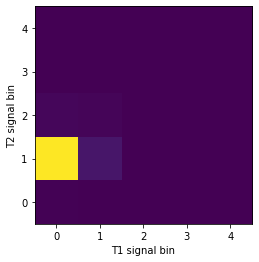

In [ ]:
hist_2d, x_edges, y_edges = np.histogram2d(p.ravel(),f.ravel(),bins=5)
plt.imshow(hist_2d.T, origin='lower')
plt.xlabel('T1 signal bin')
plt.ylabel('T2 signal bin')

Text(0, 0.5, 'T2 signal bin')

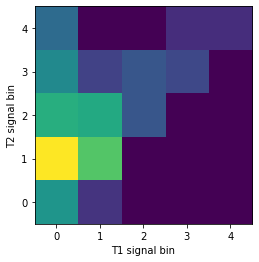

In [ ]:
hist_2d_log = np.zeros(hist_2d.shape)
non_zeros = hist_2d != 0
hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
plt.imshow(hist_2d_log.T, origin='lower')

plt.xlabel('T1 signal bin')

plt.ylabel('T2 signal bin')


In [ ]:
FF= mutual_information(hist_2d)